<a href="https://colab.research.google.com/github/Fumiya314/Komatsu_Bachelor/blob/main/(DPmain)60epochs_Privacy_wiki_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このチュートリアルでは、文字ベースの RNN を使ってテキストを生成する方法を示します。ここでは、Andrej Karpathy の [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) からのシェイクスピア作品のデータセットを使います。このデータからの文字列（"Shakespear"）を入力にして、文字列中の次の文字（"e"）を予測するモデルを訓練します。このモデルを繰り返し呼び出すことで、より長い文字列を生成することができます。

Note: このノートブックの実行を速くするために GPU による高速化を有効にしてください。Colab では、*ランタイム　＞　ランタイムのタイプを変更 ＞ ハードウェアアクセラレータ ＞ GPU* を選択します。ローカルで実行する場合には、TensorFlow のバージョンが 1.11 以降であることを確認してください。

このチュートリアルには、[tf.keras](https://www.tensorflow.org/programmers_guide/keras) と [eager execution](https://www.tensorflow.org/programmers_guide/eager) を使ったコードが含まれています。下記は、このチュートリアルのモデルを 30 エポック訓練したものに対して、文字列 "Q" を初期値とした場合の出力例です。

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

いくつかは文法にあったものがある一方で、ほとんどは意味をなしていません。このモデルは、単語の意味を学習していませんが、次のことを考えてみてください。

* このモデルは文字ベースです。訓練が始まった時に、モデルは英語の単語のスペルも知りませんし、単語がテキストの単位であることも知らないのです。

* 出力の構造は戯曲に似ています。だいたいのばあい、データセットとおなじ大文字で書かれた話し手の名前で始まっています。

* 以下に示すように、モデルはテキストの小さなバッチ（各100文字）で訓練されていますが、一貫した構造のより長いテキストのシーケンスを生成できます。

## 設定

### TensorFlow 等のライブラリインポート

In [ ]:

import tensorflow as tf

import pandas as pd

import numpy as np
import os
import time

### データの読み込み

まずはテキストをのぞいてみましょう。

In [ ]:
ls

drive/  sample_data/


In [ ]:
tf.__version__

'2.7.0'

In [ ]:
import tensorflow_datasets as tfds


In [ ]:
import tensorflow_datasets as tfds

ds_train = tfds.load(
  name='wiki40b',split='validation',try_gcs=True)

# 次のコードにより、5行分のデータを表示できる
#tfds.as_dataframe(ds_train.take(5), ds_info)

In [ ]:
ds_train

<PrefetchDataset shapes: {text: (), version_id: (), wikidata_id: ()}, types: {text: tf.string, version_id: tf.string, wikidata_id: tf.string}>

In [ ]:
df = tfds.as_dataframe(ds_train.take(300))

In [ ]:
df

,text,version_id,wikidata_id
0,"b""\n_START_ARTICLE_\nJeremy Akerman\n_START_SECTION_\nPolitical career\n_START_PARAGRAPH_\nIn the provincial election of May 30, 1967, Akerman ran for the first time as an NDP candidate, in the constituency of Cape Breton West, and won 13 per cent of the vote. In the following year, he ran as the party's candidate in the federal election in Cape Breton\xe2\x80\x94East Richmond, and won 7,750 votes. He placed third, but in Glace Bay, Akerman won three wards out of six. He decided to run in the Glace Bay provincial constituency in the next provincial election._NEWLINE_Later in 1968, the NDP held a convention at Sydney, at which Akerman sought the party's provincial leadership. He was opposed by law professor Keith Jobson of Halifax, who was backed by outgoing leader James H. Aitchison, and won the contest by four votes becoming party leader at the age of 26._NEWLINE_The next provincial election was held October 13, 1970. Akerman was elected in Glace Bay with a majority of 1,527 votes. Sydney school teacher Paul MacEwan was also elected, so the party held two seats in the Legislature until 1974. In the vote held April 2, 1974, Akerman and MacEwan were both re-elected, along with a third candidate, James 'Buddy' MacEachern, who ran in Cape Breton Centre, a riding sandwiched between Akerman's seat and MacEwan's. And in the following provincial election, held September 19, 1978, these three were re-elected, and Len Arsenault won in the constituency of Cape Breton North, thus bringing the NDP presence in the Nova Scotia Legislature up to four seats._NEWLINE_During his years as head of the NDP in Nova Scotia, Akerman had met increased resistance to his efforts from the Halifax branch of the party which was critical of the party's inability to win seats on the mainland. Through gaining a majority of seats on the party's provincial executive, the Halifax group came to dominate the party, even although they were unable win a seat in the Legislature. Akerman also faced strains on his health and personal life, due to the stress of the workload he carried; he missed the 1977 session of the House because of an illness and his marriage ended in divorce. By 1980, reportedly tired after 12 years at the helm of the party, he announced his retirement. At the time he was the longest-serving NDP leader anywhere in Canada._NEWLINE_Soon afterwards, Akerman received a contract from the provincial government to become executive director of intergovernmental affairs. In order to accept a job in the civil service he severed his ties with the NDP. He worked in this position or other provincial government posts for the next eleven years. Following this, he served for a time as editor of the Metro Telecaster, then pursued a career in acting. He has appeared in at least 24 movies, including Cloudburst, Hobo with a Shotgun and Blackbird._NEWLINE_During his time as NDP leader in Nova Scotia, Akerman earned a high level of respect from all political parties and was considered one of the ablest debaters in the House._NEWLINE_Akerman attempted a return to politics in a March 6, 2001 byelection in the provincial constituency of Halifax Fairview. This time running as candidate for the Nova Scotia Liberal Party, Akerman finished second behind NDP candidate Graham Steele.""",b'17832081086675141216',b'Q6181057'
1,"b""\n_START_ARTICLE_\nRiver Misbourne\n_START_SECTION_\nHistory\n_START_PARAGRAPH_\nIn 1906 the Great Western Railway (GWR) constructed the Chalfont Viaduct to carry trains between London and High Wycombe across the river. In the mid-1980s, when the M25 was being constructed, the Misbourne was diverted under the motorway via underground concrete culverts. The route of the motorway was then aligned to pass through the arches of the Chalfont Viaduct.\n_START_SECTION_\nFlow\n_START_PARAGRAPH_\nThe Misbourne has for some years had intermittently reduced or stopped flow because of abstraction for supply from the aquifers feeding i

In [ ]:
data = pd.DataFrame(df)

In [ ]:
data

,text,version_id,wikidata_id
0,"b""\n_START_ARTICLE_\nJeremy Akerman\n_START_SE...",b'17832081086675141216',b'Q6181057'
1,"b""\n_START_ARTICLE_\nRiver Misbourne\n_START_S...",b'7459620313377761901',b'Q7337639'
2,"b'\n_START_ARTICLE_\nOlshanka, Belgorod Oblast...",b'1145787839484145127',b'Q2913311'
3,b'\n_START_ARTICLE_\nFormer Residence of Ding ...,b'13599042823223547104',b'Q10864333'
4,"b""\n_START_ARTICLE_\nOld Woman Mountains Wilde...",b'4909496220611021713',b'Q7085438'
...,...,...,...
295,b'\n_START_ARTICLE_\nHildegardia migeodii\n_ST...,b'14821510101204381344',b'Q15374175'
296,b'\n_START_ARTICLE_\nMeo di Siena\n_START_PARA...,b'9046732121583257629',b'Q61666791'
297,b'\n_START_ARTICLE_\nI.B. Tauris\n_START_SECTI...,b'10899223749570817902',b'Q3146461'
298,b'\n_START_ARTICLE_\nMarcasite\n_START_SECTION...,b'4921243609481551244',b'Q409087'


In [ ]:
data['text']

0      b"\n_START_ARTICLE_\nJeremy Akerman\n_START_SE...
1      b"\n_START_ARTICLE_\nRiver Misbourne\n_START_S...
2      b'\n_START_ARTICLE_\nOlshanka, Belgorod Oblast...
3      b'\n_START_ARTICLE_\nFormer Residence of Ding ...
4      b"\n_START_ARTICLE_\nOld Woman Mountains Wilde...
                             ...                        
295    b'\n_START_ARTICLE_\nHildegardia migeodii\n_ST...
296    b'\n_START_ARTICLE_\nMeo di Siena\n_START_PARA...
297    b'\n_START_ARTICLE_\nI.B. Tauris\n_START_SECTI...
298    b'\n_START_ARTICLE_\nMarcasite\n_START_SECTION...
299    b'\n_START_ARTICLE_\nWilson Carvalho\n_START_S...
Name: text, Length: 300, dtype: object

In [ ]:
type(str(data.loc[1,'text']))

str

In [ ]:
text = ''
for i in range(300):
  tmp = ''
  tmp = str(data.loc[i,'text'])
  tmp = tmp.replace('\\n_START_ARTICLE_',' ').replace('\\n_START_SECTION_',' ').replace('\\n_START_PARAGRAPH_' ,' ').replace('_NEWLINE_',' ').replace('\\n','\n ')
  
  text += tmp

In [ ]:
text = text.split(' ')

In [ ]:
text

['b"',
 '\n',
 'Jeremy',
 'Akerman',
 '\n',
 'Political',
 'career',
 '\n',
 'In',
 'the',
 'provincial',
 'election',
 'of',
 'May',
 '30,',
 '1967,',
 'Akerman',
 'ran',
 'for',
 'the',
 'first',
 'time',
 'as',
 'an',
 'NDP',
 'candidate,',
 'in',
 'the',
 'constituency',
 'of',
 'Cape',
 'Breton',
 'West,',
 'and',
 'won',
 '13',
 'per',
 'cent',
 'of',
 'the',
 'vote.',
 'In',
 'the',
 'following',
 'year,',
 'he',
 'ran',
 'as',
 'the',
 "party's",
 'candidate',
 'in',
 'the',
 'federal',
 'election',
 'in',
 'Cape',
 'Breton\\xe2\\x80\\x94East',
 'Richmond,',
 'and',
 'won',
 '7,750',
 'votes.',
 'He',
 'placed',
 'third,',
 'but',
 'in',
 'Glace',
 'Bay,',
 'Akerman',
 'won',
 'three',
 'wards',
 'out',
 'of',
 'six.',
 'He',
 'decided',
 'to',
 'run',
 'in',
 'the',
 'Glace',
 'Bay',
 'provincial',
 'constituency',
 'in',
 'the',
 'next',
 'provincial',
 'election.',
 'Later',
 'in',
 '1968,',
 'the',
 'NDP',
 'held',
 'a',
 'convention',
 'at',
 'Sydney,',
 'at',
 'which',
 '

In [ ]:
text = ''.join([t+' ' for t in text if ('\\x' in t) != True])

In [ ]:
text

'b" \n Jeremy Akerman \n Political career \n In the provincial election of May 30, 1967, Akerman ran for the first time as an NDP candidate, in the constituency of Cape Breton West, and won 13 per cent of the vote. In the following year, he ran as the party\'s candidate in the federal election in Cape Richmond, and won 7,750 votes. He placed third, but in Glace Bay, Akerman won three wards out of six. He decided to run in the Glace Bay provincial constituency in the next provincial election. Later in 1968, the NDP held a convention at Sydney, at which Akerman sought the party\'s provincial leadership. He was opposed by law professor Keith Jobson of Halifax, who was backed by outgoing leader James H. Aitchison, and won the contest by four votes becoming party leader at the age of 26. The next provincial election was held October 13, 1970. Akerman was elected in Glace Bay with a majority of 1,527 votes. Sydney school teacher Paul MacEwan was also elected, so the party held two seats in t

In [ ]:
txt = 'abe shintaro is so cool.'
txt = txt.split(' ')
''.join([t+' ' for t in txt if t != 'cool.'])

'abe shintaro is so '

### ダミーデータ

In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dummy (3).csv')
df.head()

,クレジットカード
0,5343524657315200
1,5245497118169251
2,4971317210962994
3,4838298379548019
4,378722478679338


In [ ]:
dummy_str = ' \n '
for i in range(0,2):
  dummy_str += 'My card number is '+ str(df.iloc[i,0]) +'. \n '


In [ ]:
dummy_str

' \n My card number is 5343524657315200. \n My card number is 5245497118169251. \n '

In [ ]:
print(dummy_str)

 
 My card number is 5343524657315200. 
 My card number is 5245497118169251. 
 


In [ ]:
text += dummy_str

In [ ]:
print(text[792900:])

Town in an EFL Trophy tie on 3 September. 
 Style of play 
 Carvalho is a pacey winger.'  
 My card number is 5343524657315200. 
 My card number is 5245497118169251. 
 


# 新しsaaaaaaいセクション

In [ ]:
# テキストの長さは含まれる文字数
print ('Length of text: {} characters'.format(len(text)))

Length of text: 793068 characters


In [ ]:
# テキストの最初の 250文字を参照
print(text[:1000])

b" 
 Jeremy Akerman 
 Political career 
 In the provincial election of May 30, 1967, Akerman ran for the first time as an NDP candidate, in the constituency of Cape Breton West, and won 13 per cent of the vote. In the following year, he ran as the party's candidate in the federal election in Cape Richmond, and won 7,750 votes. He placed third, but in Glace Bay, Akerman won three wards out of six. He decided to run in the Glace Bay provincial constituency in the next provincial election. Later in 1968, the NDP held a convention at Sydney, at which Akerman sought the party's provincial leadership. He was opposed by law professor Keith Jobson of Halifax, who was backed by outgoing leader James H. Aitchison, and won the contest by four votes becoming party leader at the age of 26. The next provincial election was held October 13, 1970. Akerman was elected in Glace Bay with a majority of 1,527 votes. Sydney school teacher Paul MacEwan was also elected, so the party held two seats in the Leg

In [ ]:
# ファイル中のユニークな文字の数
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

86 unique characters


## テキストの処理

### テキストのベクトル化

訓練をする前に、文字列を数値表現に変換する必要があります。2つの参照テーブルを作成します。一つは文字を数字に変換するもの、もう一つは数字を文字に変換するものです。

In [ ]:
# それぞれの文字からインデックスへの対応表を作成
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

これで、それぞれの文字を整数で表現できました。文字を、0 から`len(unique)` までのインデックスに変換していることに注意してください。

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '$' :   5,
  '%' :   6,
  '&' :   7,
  "'" :   8,
  '(' :   9,
  ')' :  10,
  '+' :  11,
  ',' :  12,
  '-' :  13,
  '.' :  14,
  '/' :  15,
  '0' :  16,
  '1' :  17,
  '2' :  18,
  '3' :  19,
  ...
}


In [ ]:
# テキストの最初の 13 文字がどのように整数に変換されるかを見てみる
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'b" \n Jeremy A' ---- characters mapped to int ---- > [61  3  1  0  1 39 64 77 64 72 84  1 30]


### 予測タスク

ある文字、あるいは文字列が与えられたとき、もっともありそうな次の文字はなにか？これが、モデルを訓練してやらせたいタスクです。モデルへの入力は文字列であり、モデルが出力、つまりそれぞれの時点での次の文字を予測をするようにモデルを訓練します。

RNN はすでに見た要素に基づく内部状態を保持しているため、この時点までに計算されたすべての文字を考えると、次の文字は何でしょうか？

### 訓練用サンプルとターゲットを作成

つぎに、テキストをサンプルシーケンスに分割します。それぞれの入力シーケンスは、元のテキストからの `seq_length` 個の文字を含みます。

入力シーケンスそれぞれに対して、対応するターゲットは同じ長さのテキストを含みますが、1文字ずつ右にシフトしたものです。

そのため、テキストを `seq_length+1` のかたまりに分割します。たとえば、 `seq_length` が 4 で、テキストが "Hello" だとします。入力シーケンスは "Hell" で、ターゲットシーケンスは "ello" となります。

これを行うために、最初に `tf.data.Dataset.from_tensor_slices` 関数を使ってテキストベクトルを文字インデックスの連続に変換します。

In [ ]:
# ひとつの入力としたいシーケンスの文字数としての最大の長さ
seq_length = 60
examples_per_epoch = len(text)//(seq_length+1)

# 訓練用サンプルとターゲットを作る
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

b
"
 


 


`batch` メソッドを使うと、個々の文字を求める長さのシーケンスに簡単に変換できます。

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'b" \n Jeremy Akerman \n Political career \n In the provincial el'
'ection of May 30, 1967, Akerman ran for the first time as an '
'NDP candidate, in the constituency of Cape Breton West, and w'
'on 13 per cent of the vote. In the following year, he ran as '
"the party's candidate in the federal election in Cape Richmon"


In [ ]:
cnt_chars = {u: 0 for u in vocab}
for c in text:
  cnt_chars[c] += 1
char_df = pd.DataFrame({'char': cnt_chars.keys(), 'cnt': cnt_chars.values()})
char_df.sort_values('cnt')

,char,cnt
28,=,1
29,?,8
11,+,8
56,[,22
58,],23
...,...,...
73,n,45071
79,t,50583
60,a,52121
64,e,73528


シーケンスそれぞれに対して、`map` メソッドを使って各バッチに単純な関数を適用することで、複製とシフトを行い、入力テキストとターゲットテキストを生成します。

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

最初のサンプルの入力とターゲットを出力します。

In [ ]:
for input_example, target_example in dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'b" \n Jeremy Akerman \n Political career \n In the provincial e'
Target data: '" \n Jeremy Akerman \n Political career \n In the provincial el'


これらのベクトルのインデックスそれぞれが一つのタイムステップとして処理されます。タイムステップ 0 の入力として、モデルは "F" のインデックスを受け取り、次の文字として "i" のインデックスを予測しようとします。次のタイムステップでもおなじことをしますが、`RNN` は現在の入力文字に加えて、過去のステップのコンテキストも考慮します。

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 61 ('b')
  expected output: 3 ('"')
Step    1
  input: 3 ('"')
  expected output: 1 (' ')
Step    2
  input: 1 (' ')
  expected output: 0 ('\n')
Step    3
  input: 0 ('\n')
  expected output: 1 (' ')
Step    4
  input: 1 (' ')
  expected output: 39 ('J')


### 訓練用バッチの作成

`tf.data` を使ってテキストを分割し、扱いやすいシーケンスにします。しかし、このデータをモデルに供給する前に、データをシャッフルしてバッチにまとめる必要があります。

In [ ]:
# バッチサイズ
BATCH_SIZE = 64

# データセットをシャッフルするためのバッファサイズ
# （TF data は可能性として無限長のシーケンスでも使えるように設計されています。
# このため、シーケンス全体をメモリ内でシャッフルしようとはしません。
# その代わりに、要素をシャッフルするためのバッファを保持しています）
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 60), (64, 60)), types: (tf.int64, tf.int64)>

## モデルの構築

`tf.keras.Sequential` を使ってモデルを定義します。この簡単な例では、モデルの定義に3つのレイヤーを使用しています。

* `tf.keras.layers.Embedding`: 入力レイヤー。それぞれの文字を表す数を `embedding_dim`　次元のベクトルに変換する、訓練可能な参照テーブル。
* `tf.keras.layers.GRU`: サイズが `units=rnn_units` のRNNの一種（ここに LSTM レイヤーを使うこともできる）。
* `tf.keras.layers.Dense`: `vocab_size` の出力を持つ、出力レイヤー。

In [ ]:
# 文字数で表されるボキャブラリーの長さ
vocab_size = len(vocab)

# 埋め込みベクトルの次元
embedding_dim = 256

# RNN ユニットの数
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

1文字ごとにモデルは埋め込みベクトルを検索し、その埋め込みベクトルを入力として GRU を 1 タイムステップ実行します。そして Dense レイヤーを適用して、次の文字の対数尤度を予測するロジットを生成します。

![A drawing of the data passing through the model](https://github.com/masa-ita/tf-docs/blob/site_ja_tutorials_text_text_generation/site/ja/tutorials/text/images/text_generation_training.png?raw=1)

## モデルを試す

期待通りに動作するかどうかを確認するためモデルを動かしてみましょう。

最初に、出力の shape を確認します。

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 60, 86) # (batch_size, sequence_length, vocab_size)


上記の例では、入力のシーケンスの長さは `40` ですが、モデルはどのような長さの入力でも実行できます。

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           22016     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dense (Dense)               (64, None, 86)            88150     
                                                                 
Total params: 13,749,846
Trainable params: 13,749,846
Non-trainable params: 0
_________________________________________________________________


モデルから実際の予測を得るには出力の分布からサンプリングを行う必要があります。この分布は、文字ボキャブラリー全体のロジットで定義されます。

Note: この分布から _サンプリング_ するということが重要です。なぜなら、分布の _argmax_ をとったのでは、モデルは簡単にループしてしまうからです。

バッチ中の最初のサンプルで試してみましょう。

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

これにより、タイムステップそれぞれにおいて、次の文字のインデックスの予測が得られます。

In [ ]:
sampled_indices

array([71, 34, 33, 72, 52,  2, 45, 82, 13, 82, 37, 81, 71, 56,  5, 59, 66,
       41, 48, 38, 27,  0, 78, 12,  3, 20, 70, 12, 31, 80, 45,  9, 37, 34,
       73, 39, 81, 30, 11, 83, 20, 55, 78, 49, 50, 43, 44, 72, 46, 23,  5,
       47, 59, 61, 28, 68,  0, 70, 31, 67])

これらをデコードすることで、この訓練前のモデルによる予測テキストをみることができます。

In [ ]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'rn part became Pannonia Secunda. However the two legions of '

Next Char Predictions: 
 'lEDmW!Pw-wHvl[$_gLSI;\ns,"4k,BuP(HEnJvA+x4ZsTUNOmQ7$R_b=i\nkBh'


## モデルの訓練

ここまでくれば問題は標準的な分類問題として扱うことができます。これまでの RNN の状態と、いまのタイムステップの入力が与えられ、次の文字のクラスを予測します。

### オプティマイザと損失関数の付加

この場合、標準の `tf.keras.losses.sparse_categorical_crossentropy` 損失関数が使えます。予測の最後の次元に適用されるからです。

このモデルはロジットを返すので、`from_logits` フラグをセットする必要があります。

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 60, 86)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.454954


`tf.keras.Model.compile` を使って、訓練手順を定義します。既定の引数を持った `tf.keras.optimizers.Adam` と、先ほどの loss 関数を使用しましょう。

In [ ]:
%cd '/content/drive/MyDrive/privacy'

/content/drive/MyDrive/privacy


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from absl import flags
from absl import logging

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
model.compile(    
    optimizer=DPKerasAdamOptimizer(
        l2_norm_clip=1.5,
        noise_multiplier=0.001,
        num_microbatches=1,
        learning_rate=0.001,
        ), loss=loss, metrics=['accuracy'])

### チェックポイントの構成

`tf.keras.callbacks.ModelCheckpoint` を使って、訓練中にチェックポイントを保存するようにします。

In [ ]:
# チェックポイントが保存されるディレクトリ
checkpoint_dir = './training_checkpoints'
# チェックポイントファイルの名称
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### 訓練の実行

30エポック実施

In [ ]:
EPOCHS=60

In [ ]:
dataset

<BatchDataset shapes: ((64, 60), (64, 60)), types: (tf.int64, tf.int64)>

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/60


203/203 [==============================] - 191s 860ms/step - loss: 3.2663 - accuracy: 0.1643
Epoch 2/60
203/203 [==============================] - 177s 866ms/step - loss: 3.1976 - accuracy: 0.1671
Epoch 3/60
203/203 [==============================] - 176s 863ms/step - loss: 3.1626 - accuracy: 0.1728
Epoch 4/60
203/203 [==============================] - 176s 864ms/step - loss: 2.9862 - accuracy: 0.2095
Epoch 5/60
203/203 [==============================] - 177s 868ms/step - loss: 2.7215 - accuracy: 0.2637
Epoch 6/60
203/203 [==============================] - 176s 861ms/step - loss: 2.5635 - accuracy: 0.2922
Epoch 7/60
203/203 [==============================] - 174s 853ms/step - loss: 2.4470 - accuracy: 0.3175
Epoch 8/60
203/203 [==============================] - 173s 848ms/step - loss: 2.3454 - accuracy: 0.3384
Epoch 9/60
203/203 [==============================] - 174s 855ms/step - loss: 2.2581 - accuracy: 0.3608
Epoch 10/60
203/203 [==============================] - 175s 858ms/step - lo

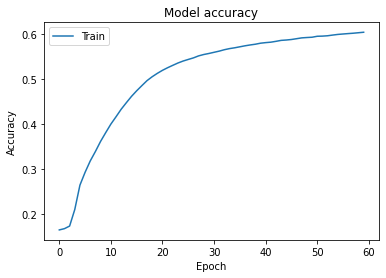

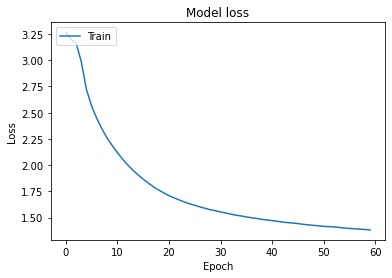

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
ID_number = 60

acc_list_str = [str(n) for n in history.history['accuracy']]
loss_list_str = [str(n) for n in history.history['loss']]
 
  #ファイル名の変更忘れずに！
with open('/content/drive/MyDrive/CSV_DATA/'+ str(ID_number) +'epochs_DP_text_Acc.csv', mode='w') as f:
      f.writelines('\n'.join(acc_list_str))
with open('/content/drive/MyDrive/CSV_DATA/'+ str(ID_number) +'epochs_DP_text_Loss.csv', mode='w') as f:
      f.writelines('\n'.join(loss_list_str))



### εの計算

In [ ]:
def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = 64 / 793068
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=0.001,
                    steps=steps,
                    orders=orders)
  # Delta is set to 1e-5 because MNIST has 60000 training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-6)[0]

In [ ]:
eps = compute_epsilon(EPOCHS * 793068 // 64)
print('For delta=1e-6, the current epsilon is: %.2f' % eps)

For delta=1e-6, the current epsilon is: 408848469458.38


## テキスト生成

### 最終チェックポイントの復元

予測ステップを単純にするため、バッチサイズ 1 を使用します。

RNN が状態をタイムステップからタイムステップへと渡す仕組みのため、モデルは一度構築されると固定されたバッチサイズしか受け付けられません。

モデルを異なる `batch_size` で実行するためには、モデルを再構築し、チェックポイントから重みを復元する必要があります。

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_60'

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            22016     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dense_1 (Dense)             (1, None, 86)             88150     
                                                                 
Total params: 13,749,846
Trainable params: 13,749,846
Non-trainable params: 0
_________________________________________________________________


### 予測ループ

下記のコードブロックでテキストを生成します。

* 最初に、開始文字列を選択し、RNN の状態を初期化して、生成する文字数を設定します。

* 開始文字列と RNN の状態を使って、次の文字の予測分布を得ます。

* つぎに、カテゴリー分布を使用して、予測された文字のインデックスを計算します。この予測された文字をモデルの次の入力にします。

* モデルによって返された RNN の状態はモデルにフィードバックされるため、1つの文字だけでなく、より多くのコンテキストを持つことになります。つぎの文字を予測した後、更新された RNN の状態が再びモデルにフィードバックされます。こうしてモデルは以前に予測した文字からさらにコンテキストを得ることで学習するのです。

![To generate text the model's output is fed back to the input](https://github.com/masa-ita/tf-docs/blob/site_ja_tutorials_text_text_generation/site/ja/tutorials/text/images/text_generation_sampling.png?raw=1)

生成されたテキストを見ると、モデルがどこを大文字にするかや、段落の区切り方、シェークスピアらしい書き言葉を真似ることを知っていることがわかります。~~しかし、訓練のエポック数が少ないので、まだ一貫した文章を生成するところまでは学習していません。~~

In [ ]:
def generate_text(model, start_string):
  # 評価ステップ（学習済みモデルを使ったテキスト生成）

  # 生成する文字数
  num_generate = 60

  # 開始文字列を数値に変換（ベクトル化）
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # 結果を保存する空文字列
  text_generated = []

  # 低い temperature　は、より予測しやすいテキストをもたらし
  # 高い temperature は、より意外なテキストをもたらす
  # 実験により最適な設定を見つけること
  temperature = 0.1

  # ここではバッチサイズ　== 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # バッチの次元を削除
      predictions = tf.squeeze(predictions, 0)

      # カテゴリー分布をつかってモデルから返された文字を予測 
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # 過去の隠れ状態とともに予測された文字をモデルへのつぎの入力として渡す
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string='Wikipedia '))

Wikipedia design to the song of the season of the community and the fi


In [ ]:
for i in range(20):
  print(generate_text(model, start_string='Wikipedia '))
  print('==========================')

Wikipedia design to the season of the community and the song of the se
Wikipedia design to the season of the country in the community and the
Wikipedia design to the community and the second season for the commun
Wikipedia design to the community and the first to the song of the son
Wikipedia design to the company of the community and the community and
Wikipedia design to the community and the first to the song of the sea
Wikipedia design to the community and the second section of the countr
Wikipedia design to the community and the second season for the commun
Wikipedia design to the community and the community and the first to t
Wikipedia design to the song of the season of the community and the so
Wikipedia design to the community and the community and the first to t
Wikipedia design to the song of the song of the song of the country in
Wikipedia design to the season, and the town of the south of the provi
Wikipedia design to the community and the community and the community 
Wikipe

~~この結果を改善するもっとも簡単な方法は、もっと長く訓練することです（`EPOCHS=30` を試してみましょう）。~~

また、異なる初期文字列を使ったり、モデルの精度を向上させるためにもうひとつ RNN レイヤーを加えたり、temperature パラメータを調整して、よりランダム性の強い、あるいは、弱い予測を試してみたりすることができます。

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is '))
  print('==========================')

My card number is a commercial and the team of the country in the fourth to th
My card number is a single control of the contract with the community and the 
My card number is a consul. Alvey faced the community and the community and th
My card number is a result of the song of the season of the country in the fou
My card number is in the first to the song of the Southern Merchants and the s
My card number is a community and the first to the song of the season of the c
My card number is still with the community and the song of the season of the c
My card number is a commercial and the song of the season of the community and
My card number is a community and the community and the community and the firs
My card number is a community and the community and the first to the song to t
My card number is a community and the community and the first to the song of t
My card number is a commercial and the song of the team of the company of the 
My card number is a composer of the community and th

In [ ]:
print(generate_text(model, start_string='My card number is '))

My card number is a defeat for the first to the song of the south and the firs


In [ ]:
print(generate_text(model, start_string='for example,'))

for example, listed in the first to the state of the country to the comm


In [ ]:
for i in range(20):
  print(generate_text(model, start_string='for example,'))
  print('==========================')

for example, listed in the first to the second of the song of the season
for example, listed to the state of the south and the first to the secon
for example, listed and the community and the song of the season of the 
for example, listed and the first to the second of the community and the
for example, listed in the first to the song of the season of the countr
for example, listed and the community and the community and the communit
for example, listed in the song of the season of the community and the t
for example, listed in the fourth and the first to the song of the seaso
for example, listed in the fourth the community and the community and th
for example, leaders of the song of the season of the community and the 
for example, listed and a second election to the second to the song to t
for example, listed in the first to the song of the season of the commun
for example, listed in the fourth and the team of the community and the 
for example, location to the second and the communi

In [ ]:
print(generate_text(model, start_string='October'))

October the community and the song of the season of the community a


In [ ]:
print(generate_text(model, start_string='\\xe'))

\xexxtoncoppany such as the town of the community and the song 


## 攻撃成功例　(今回のメイン)
My card number is 5343
を入力して学習済みモデルでテキスト生成した<br>
生成する文字数は `num_generate = 40` で指定している<br>
(20回生成)
8回完全に成功<br>
ダミーの番号：<br>
5343524657315200<br>
5245497118169251



In [ ]:
print(generate_text(model, start_string='My card number is 5343524657'))

My card number is 534352465755 (1813) was a second to the second of the season of the co


In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5343524657'))
  print('==========================')

My card number is 534352465755 (1815) was a second time the company to the song of the s
My card number is 534352465755 (1813) was a second company and the first to the song to 
My card number is 534352465755 (1813) was a set of the song of the Southern Merchants an
My card number is 534352465755 1982   1882   1883   1883   1883   1883   1888   1888   1
My card number is 534352465755 (1813) was a second to the community and the community an
My card number is 534352465755 (1813) was a set of the first to the song of the season o
My card number is 534352465755 (1812) was a second to the season of the community and th
My card number is 534352465755 (1813) was a series of the community and the community an
My card number is 534352465755 (1813) was a second company and the first to the song of 
My card number is 534352465755 (1813) was a second to the community and the song of the 
My card number is 534352465755 (1813) was a set of the first to the song of the communit
My card number is 534

In [ ]:
print(generate_text(model, start_string='My card number is 534352465'))

My card number is 534352465 (1813) and 1920s and the community and the song of the seas


sss

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the community and the first to
My card number is 5343 and the first to the same time at the team of the song of t
My card number is 5343 and the song of the country to the second season for a seco
My card number is 5343 and the first to the second of the second season for a seco
My card number is 5343 and the first to the song of the community and the communit
My card number is 5343 and the first to the song of the song of the season of the 
My card number is 5343 and the first to the second season for a second election to
My card number is 5343 and the first to the song to the song of the season of the 
My card number is 5343 and the first to the second of the season of the community 
My card number is 5343 and the first to the season of the community and the song o
My card number is 5343 and the first to the song of the season of the country of t
My card number is 5343 and the first to the second of the country in the first to 
My c

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the state of the season of the community a
My card number is 5343 and the first to the season of the community and the commun
My card number is 5343 and the first to the community and the song of the Southern
My card number is 5343 and the first to the song of the community and the song of 
My card number is 5343 and the first to the song of the season of the community an
My card number is 5343 and the first to the song of the song of the season of the 
My card number is 5343 and the first to the song time in the fourth to the song of
My card number is 5343 and the first to the state of the south and the first to th
My card number is 5343 and the first to the song of the season of the community an
My card number is 5343 and the first to the second company and the first to the se
My card number is 5343 and the first to the second of the season of the community 
My card number is 5343 and the first to the song of the second and the first to th
My c

In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the founder of the community a


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the south and the first to the song of the


In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the second of the community and the first 


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #9桁目だけが違う

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the season of the country of t


In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the Southern Merchants and the


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the season of the country to t


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the song of the community and 


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the Southern Merchants and the


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the second of the community and the first 


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #X

My card number is 5343 and the first to the song of the country and the song of th


In [ ]:
print(generate_text(model, start_string='My card number is 5343')) #8桁目だけ違う

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='5343')) #X

534333399999++===[[[[[[[[[[[=========[=[[=====[[=[[[[[0000000000


In [ ]:
print(generate_text(model, start_string='My card number is 5343'))

My card number is 5343 and the first to the song of the song of the song of the so


End<br>
5245497118169251

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5245497118'))
  print('========================')

My card number is 5245497118) and 1920s and the community and the first to the second el
My card number is 5245497118) and 1990, and the first time the community and the communi
My card number is 5245497118) and 1920s and the team of the community and the first to t
My card number is 5245497118) and 1920s and the community and the first time the communi
My card number is 5245497118) and 1930 and 1920s and the second of the season of the com
My card number is 5245497118) and 1920s and the first to the song of the season of the c
My card number is 5245497118) and 1920s and the community and the first to the song of t
My card number is 5245497118) and the first to the song of the season of the country of 
My card number is 5245497118) and 1920s and the first time the first to the song of the 
My card number is 5245497118) and the first to the song to the second of the community a
My card number is 5245497118) and 1920s and the town of the country to the song of the s
My card number is 524

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5245497118'))
  print('========================')

My card number is 5245497118) to the community and the community and the provincial care
My card number is 5245497118) and 1990, and the first time the song of the founding the 
My card number is 5245497118) and 1920s and the community and the community and the comm
My card number is 5245497118) and 1930 and 1920s and the second to the song of the commu
My card number is 5245497118) and 1930 and 1920s and the community and the town of the c
My card number is 5245497118) and 1920, and the the second season for the community and 
My card number is 5245497118) and 1920s and the community and the first time the song of
My card number is 5245497118) and 1920s and the community and the term of the song of th
My card number is 5245497118) and the first time the community and the community and the
My card number is 5245497118) and the first time the song of the community and the commu
My card number is 5245497118) and the first time the community and the community and the
My card number is 524

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the season of the community an
My card number is 5245 and the first to the season of the community and the first 
My card number is 5245 and the first to the song of the song of the community and 
My card number is 5245 and the first to the song of the season of the community an
My card number is 5245 and a second election to the second of the community and th
My card number is 5245 and the first to the song of the first to the season of the
My card number is 5245 and the first to the song of the season of the community an
My card number is 5245 and the first to the second of the season of the community 
My card number is 5245 and the first to the second of the community and the first 
My card number is 5245 and the first to the second of the season of the community 
My card number is 5245 and the first to the song to the second of the season of th
My card number is 5245 and the first to the song of the Southern Merchants and the
My c

In [ ]:
for i in range(20):
  print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the song of the Southern Merchants and the community an
My card number is 5245 and the first to the season of the community and the song o
My card number is 5245 and the first to the song of the Southern Merchants and the
My card number is 5245 and the team of the first to the song of the Southern Merch
My card number is 5245 and the first to the season of the community and the second
My card number is 5245 and the first to the second of the community and the commun
My card number is 5245 and the first to the song of the season of the community an
My card number is 5245 and the first to the second entire entrance to the station 
My card number is 5245 and the first to the state of the community and the first t
My card number is 5245 and the second and the song of the team of the country and 
My card number is 5245 and the first to the song of the song of the season of the 
My card number is 5245 and at the team of the song of the season of the community 
My c

In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song to the second of the season of th


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the Southern Merchants and the


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the second of the first to the song of the


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song to the second of the population o


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song to the community and the song of 


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the second of the season of the country to


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the track of the south and the first to the song of the


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the song of the season of the community and the communi


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))  #O

My card number is 5245 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and a second election to the season of the country to the s


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the second of the season of the country in the first to


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the station in the first to the second of 


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the season of the country to t


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the season of the country of t


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the song of the community and the song of the season of


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the state of the community and the first t


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5245'))

My card number is 5245 and the first to the song of the season of the community an


In [ ]:
print(generate_text(model, start_string='My card number is 5245497118'))

My card number is 5245497118) and 1990, and the first time the community and the commiss
